# Cloud Coverage Analysis

In [2]:
import geemap
from geemap import colormaps
from geemap import foliumap
import ee
import sys
sys.path.append('C:/Users/wb514197/Repos/GEE_Zonal/src')
from gee_tools import Catalog, ZonalStats
from gee_helpers import get_zonal_res
import pandas as pd
import os
import glob
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from geemap.conversion import *
import geopandas as gpd

eemont not available
Google Drive tools are not available


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.path.realpath("..")

'C:\\Users\\wb514197\\Repos\\pacific-observatory'

In [5]:
ee.Initialize()

In [6]:
# pac_dir = os.path.join(os.path.expanduser("~"), 'data', 'pacific')
pac_dir = 'X:/data/pacific'
png_dir = os.path.join(pac_dir, "PNG")
out_dir = os.path.join(png_dir, 'output')
min_dir = os.path.join(png_dir, 'mining')

In [9]:
pac_path = r'C:\Users\wb514197\WBG\EEAPV Pacific Observatory Files - Geospatial and Big Data\Data\Admin Boundaries'
pac_adm0 = gpd.read_file(os.path.join(pac_path, "Adm0_Pacific.shp"))
pac_adm0 = pac_adm0.to_crs('EPSG:4326')

In [10]:
pac_adm0.WB_ADM0_NA.unique()

array(['American Samoa (U.S.)', 'Baker Island (U.S.)',
       'Cook Islands (N.Z.)', 'Fiji', 'French Polynesia (Fr.)',
       'Guam (U.S.)', 'Howland Island (U.S.)', 'Jarvis Island (U.S.)',
       'Johnston Atoll (U.S.)', 'Kingman Reef (U.S.)', 'Kiribati',
       'Marshall Islands', 'Federated States of Micronesia',
       'Midway Island (U.S.)', 'Nauru', 'New Caledonia (Fr.)',
       'Niue (N.Z.)', 'Norfolk Island (Aus.)',
       'Northern Mariana Islands (U.S.)', 'Palau', 'Palmyra Atoll (U.S.)',
       'Papua New Guinea', 'Pitcairn Islands (U.K.)', 'Samoa',
       'Solomon Islands', 'Tokelau (N.Z.)', 'Tonga', 'Tuvalu', 'Vanuatu',
       'Wake Island (U.S.)', 'Wallis and Futuna (Fr.)'], dtype=object)

In [11]:
sel = [
    'Federated States of Micronesia', 
    'Fiji',
    'Kiribati',
    'Marshall Islands',
    'Nauru',
    'Palau',
    'Papua New Guinea',
    'Samoa',
    'Solomon Islands',
    'Tonga',
    'Tuvalu',
    'Vanuatu'
]

In [12]:
pac = pac_adm0.loc[pac_adm0.WB_ADM0_NA.isin(sel)].copy()

In [13]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('cf_cvg') #.filterDate('2019-01-01', "2021-12-31")

In [14]:
def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())

In [15]:
aoi = geopandas_to_ee(pac)

Check cloud issues

In [16]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('cf_cvg')# .filterDate('2019-01-01', "2021-12-31")
# one = cf_cvg.first().clip(aoi)
# one = one.mask(one)

In [17]:
def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())

In [18]:
coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

In [19]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
res = res.getInfo()

In [20]:
df_gt0 = get_zonal_res(res)

In [21]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
res = res.getInfo()

In [22]:
df_gte0 = get_zonal_res(res)

In [23]:
df_gt0.columns

Index(['20140101_cf_cvg', '20140201_cf_cvg', '20140301_cf_cvg',
       '20140401_cf_cvg', '20140501_cf_cvg', '20140601_cf_cvg',
       '20140701_cf_cvg', '20140801_cf_cvg', '20140901_cf_cvg',
       '20141001_cf_cvg',
       ...
       'OBJECTID', 'Region', 'SPC', 'Shape_Area', 'Shape_Leng', 'UN_m49',
       'WB_ADM0_CO', 'WB_ADM0_NA', 'incomeG', 'lendingC'],
      dtype='object', length=115)

In [24]:
# pac_df = pac.drop(columns='geometry')
# pac_df.columns

In [25]:
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
# df_gt0.loc[:, pac_df.columns]
# import numpy as np
# list(np.invert(filt))

In [26]:
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))

In [27]:
df_pct.columns

Index(['FID_100', 'ISO3', 'ISO_A2', 'OBJECTID', 'Region', 'SPC', 'Shape_Area',
       'Shape_Leng', 'UN_m49', 'WB_ADM0_CO',
       ...
       '20210901_cf_cvg', '20211001_cf_cvg', '20211101_cf_cvg',
       '20211201_cf_cvg', '20220101_cf_cvg', '20220201_cf_cvg',
       '20220301_cf_cvg', '20220401_cf_cvg', '20220501_cf_cvg',
       '20220601_cf_cvg'],
      dtype='object', length=115)

In [28]:
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col

In [29]:
df_pct.rename(rename_func, axis=1, inplace=True)

In [30]:
df_pct.columns

Index(['FID_100', 'ISO3', 'ISO_A2', 'OBJECTID', 'Region', 'SPC', 'Shape_Area',
       'Shape_Leng', 'UN_m49', 'WB_ADM0_CO',
       ...
       'pct__20210901', 'pct__20211001', 'pct__20211101', 'pct__20211201',
       'pct__20220101', 'pct__20220201', 'pct__20220301', 'pct__20220401',
       'pct__20220501', 'pct__20220601'],
      dtype='object', length=115)

In [31]:
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'WB_ADM0_NA',
    j = 'date',
    sep = "__"
)

In [32]:
df_pct_re.reset_index(inplace=True)

In [33]:
df_pct_re.loc[:,"date"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [34]:
# df_pct_re.to_csv(os.path.join(out_dir, "adm0_pct_cloud.csv"))

In [35]:
sns.set()
# sns.reset_defaults()

<AxesSubplot:xlabel='date', ylabel='pct'>

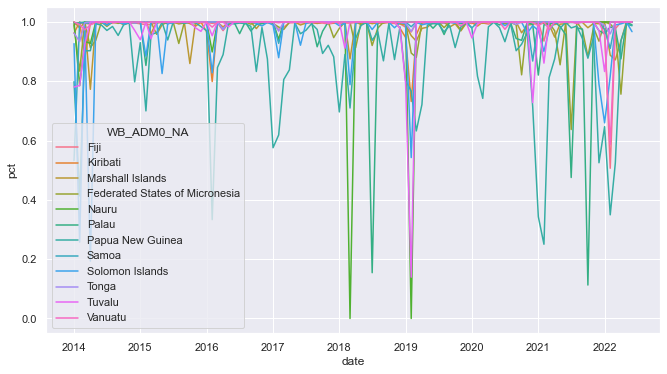

In [36]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_pct_re, x="date", y="pct", hue='WB_ADM0_NA')
# ax.set(ylim=(0, 36000))

Map cloud

In [37]:
cent = aoi.geometry().centroid().getInfo()['coordinates']

In [38]:
# pac_adm0.representative_point()

In [39]:
vis_cloud = {
    'bands': ['cf_cvg'], 
    'palette': ['ffffff', 'cc0013'], 
    'min': 0, 
    'max': 1, 
    'opacity': 0.5
}

In [40]:
one = coverage_gt0.filterDate('2020-02-01', "2020-03-01")

In [41]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [42]:
Map = geemap.Map(center = [cent[1], cent[0]], zoom=6)
# Map.addLayer(aoi, vis_countries, "Country")
Map.addLayer(one, vis_cloud, 'Cloud Free Coverage')
Map.addLayerControl()
Map

Map(center=[-7.29794580250415, 147.91153951306083], controls=(WidgetControl(options=['position', 'transparent_…

In [45]:
# to remove
# Map.remove_layer(Map.find_layer('Cloud Free Coverage'))

In [53]:
# viirs_col_raw = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG") \
#     .select('avg_rad') \
#     .filterDate('2020-01-01', "2021-06-01")

In [68]:
viirs_col = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .filterDate('2020-01-01', "2021-06-01")
#     .select('avg_rad') \

In [74]:
def prepareImage(img):
    img = img.clip(aoi)
    rad = img.select('avg_rad')
    cf_cvg = img.select('cf_cvg') #.rename('avg_rad')
    cf_eq0 = cf_cvg.gt(0)
    img_masked = rad.mask(cf_eq0)
    
    return img_masked

In [75]:
# def prepareImage(img):
#     img_clip = img.clip(aoi)
#     img_masked = img_clip.mask(img_clip.gt(0))
#     return img_masked

In [76]:
# viirs_col_clip_raw = viirs_col_raw.map(prepareImage)

In [77]:
viirs_col_clip = viirs_col.map(prepareImage)

In [78]:
# def ymList_ee(self):
#     '''
#     Create list of year/month pairs from a given dataset using EE
#     '''
#     def iter_func(image, newlist):
#         date = ee.String(image.date().format("YYYY-MM"))
#         newlist = ee.List(newlist);
#         return ee.List(newlist.add(date).sort())
#     ymd = self.iterate(iter_func, ee.List([]))
#     return ee.List(ymd).distinct()

In [79]:
# dates = ymList_ee(viirs_col_clip)

In [80]:
# dates = dates.getInfo()

In [81]:
pal = colormaps.get_palette('viridis', 20)
vis_params = {
    'bands': ['avg_rad'], 
    'palette': pal, 
    'min': 0.0, 
    'max': 5.0, 
    'opacity': 1.0
}

In [84]:
one = viirs_col_clip.filterDate('2020-02-01', "2020-03-01")

In [85]:
Map2 = geemap.Map(center = [cent[1], cent[0]], zoom=6)
Map2.addLayer(one, vis_params, "VIIRS")
Map2.addLayerControl()
Map2

Map(center=[-7.29794580250415, 147.91153951306083], controls=(WidgetControl(options=['position', 'transparent_…

In [65]:
Map2 = geemap.Map(center = [cent[1], cent[0]], zoom=6)
Map2.addLayer(viirs_col_clip.first(), vis_params, "VIIRS")
Map2.addLayerControl()
Map2

Map(center=[-7.29794580250415, 147.91153951306083], controls=(WidgetControl(options=['position', 'transparent_…